In [15]:
import pandas as pd
from safegraph_py_functions import safegraph_py_functions as sgpy
import os
from dotenv import load_dotenv, find_dotenv
from loguru import logger

In [16]:
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)
os.chdir(os.environ.get("ROOT_DIR"))
from src import DATA_DIR
raw_data_dir = DATA_DIR / 'raw'

In [17]:
# if import is 0 it reads the data from the existing file
# otherwise reads in the raw data an makes a unified dataset
IMPORT = 0 

In [18]:
# Read in all patterns files in the monthly-patterns folder
def get_files():
    patterns_path = raw_data_dir / "monthly-patterns"
    files = []
    for f in patterns_path.glob("**/*.csv.gz"):
        files.append(f)
    return files

In [19]:
def filter_to_philly(df):
    # zip codes are read as integers rather than strings so we add leading zeros.
    # this is not strictly necessary since Philadelphia zipcodes don't have leading zeros.
    
    # Philadelphia selection
    # HK: adding leading zeros because some zipcodes in MA are 0191X.
    df['postal_code'] = df['postal_code'].apply(lambda x: ('00000'+str(x))[-5:])
    in_philly = df['postal_code'].astype(str).str.startswith("191")
    df = df.loc[in_philly]
    df = df[['safegraph_place_id','date_range_start','postal_code', 
             'raw_visit_counts', 'raw_visitor_counts']]
    
    return df

In [73]:
if IMPORT == 1:
    philly_patterns = []
    files = get_files()
    for i, f in enumerate(files):
        print(f)
        philly_patterns.append(filter_to_philly(pd.read_csv(f)))
    philly_patterns = pd.concat(philly_patterns)
    philly_patterns.to_csv(
    DATA_DIR / "processed" / "kmeans_patterns.csv.tar.gz", index=False
    )
else:
    philly_patterns = pd.read_csv(DATA_DIR / "processed" / "philly_patterns.csv.tar.gz", low_memory = False)

In [74]:
philly_patterns.columns

Index(['placekey_x', 'safegraph_place_id', 'location_name_x',
       'street_address_x', 'city_x', 'region_x', 'postal_code_x',
       'safegraph_brand_ids_x', 'brands_x', 'date_range_start',
       'date_range_end', 'raw_visit_counts', 'raw_visitor_counts',
       'visits_by_day', 'poi_cbg', 'visitor_home_cbgs', 'visitor_daytime_cbgs',
       'visitor_work_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'parent_safegraph_place_id', 'location_name_y',
       'safegraph_brand_ids_y', 'brands_y', 'top_category', 'sub_category',
       'naics_code', 'latitude', 'longitude', 'street_address_y', 'city_y',
       'region_y', 'postal_code_y', 'iso_country_code', 'phone_number',
       'open_hours', 'category_tags', 'valid_to', 'valid_from', 'placekey_y',
       'opened_on', 'closed_on', 'tracking_opened_since',
 

In [75]:
philly_patterns= philly_patterns[['safegraph_place_id','date_range_start', 'date_range_end',
             'raw_visit_counts', 'raw_visitor_counts', 'poi_cbg','top_category']]
philly_patterns['poi_cbg'] = philly_patterns['poi_cbg'].astype(int)
philly_patterns['date_range_start'] = pd.to_datetime(philly_patterns['date_range_start'])
philly_patterns['date_range_end'] = pd.to_datetime(philly_patterns['date_range_end'].apply(lambda x: x[:10]))

In [76]:
census_path = DATA_DIR / 'raw' / 'open-census-data'
files = [file for file in census_path.glob('**/cbg_b19.csv')]
census = pd.read_csv(files[0])
census =  census[['census_block_group','B19013e1']]

In [77]:
philly_patterns = philly_patterns.merge(census, left_on = 'poi_cbg', right_on = 'census_block_group', how = 'left')
philly_patterns.drop(columns = 'census_block_group', inplace = True)

In [78]:
philly_patterns['income_missing'] = philly_patterns['B19013e1'].isna().astype(int)
philly_patterns['B19013e1'].fillna(value=philly_patterns['B19013e1'].mean(), inplace=True)

In [79]:
# for files with information disaggregated at the state level, keep only the country-wide info
def keep_total_level(norm_stats):
    if 'region' in norm_stats.columns:
        if len(norm_stats[norm_stats['region'] == 'ALL_STATES']) == 0:
            raise ValueError('no region named "ALL_STATES"')
        norm_stats = norm_stats[norm_stats['region'] == 'ALL_STATES']
        norm_stats = norm_stats.drop(columns = ['region'])
    return norm_stats


patterns_path = raw_data_dir / "monthly-patterns"

    
norm_files = [f for f in patterns_path.glob("**/normalization_stats.csv")]
#read in normalization data
norm_stats = pd.concat([keep_total_level(pd.read_csv(file)) for file in norm_files])
norm_stats['year'] = norm_stats['year'].astype(int)
norm_stats['month'] = norm_stats['month'].astype(int)
norm_stats['day'] = norm_stats['day'].astype(int)
# HK: I only downloaded patterns data from 2019 onwards due to memory constraints
norm_stats = norm_stats[norm_stats['year'] >= 2019]
norm_stats.reset_index(inplace = True, drop = True) 

In [80]:
norm_stats.head()

,year,month,day,total_visits,total_devices_seen,total_home_visits,total_home_visitors
0,2019,3,1,69304245,19864233,27636202,15964091
1,2019,3,2,62486898,19501615,26199538,15565360
2,2019,3,3,55210974,19444962,27158187,16285916
3,2019,3,4,63672615,19781861,27567027,16034434
4,2019,3,5,63906175,19171193,26656320,15457780


In [81]:
norm_stats['date'] = pd.to_datetime((norm_stats.year*10000+norm_stats.month*100+norm_stats.day).apply(str),format='%Y%m%d')

In [89]:
date_ranges = philly_patterns[['date_range_start', 'date_range_end']].drop_duplicates().sort_values('date_range_start').reset_index(drop = True)

In [90]:
date_ranges

,date_range_start,date_range_end
0,2019-01-01,2019-02-01
1,2019-02-01,2019-03-01
2,2019-03-01,2019-04-01
3,2019-04-01,2019-05-01
4,2019-05-01,2019-06-01
5,2019-06-01,2019-07-01
6,2019-07-01,2019-08-01
7,2019-08-01,2019-09-01
8,2019-09-01,2019-10-01
9,2019-10-01,2019-11-01


In [99]:
def get_date_range(x): 
    mask = (date_ranges['date_range_start'] <= x) & (date_ranges['date_range_end'] > x)
    return date_ranges.loc[mask,'date_range_start'].values[0]

In [103]:
norm_stats['date_range_start'] = norm_stats.date.apply(get_date_range)

In [106]:
norm_stats = norm_stats[['date_range_start', 'total_visits', 'total_devices_seen']].groupby('date_range_start').agg('sum').reset_index()

In [109]:
philly_patterns = philly_patterns.merge(norm_stats, on = 'date_range_start')
philly_patterns['visit_count_norm'] = 1000000*philly_patterns['raw_visit_counts']/philly_patterns['total_visits']
philly_patterns['visitor_count_norm'] = 1000000*philly_patterns['raw_visitor_counts']/philly_patterns['total_devices_seen']

In [13]:
check = philly_patterns.groupby(['safegraph_place_id']).nunique()

In [14]:
check.loc[check['B19013e1']>1]

,date_range_start,raw_visit_counts,raw_visitor_counts,poi_cbg,top_category,B19013e1,income_missing
safegraph_place_id,,,,,,,
sg:002e331cebec461d932e13cee0e01ca3,22,22,22,2,1,2,2
sg:01243aca691a4d8aadc71508c7f896d8,22,22,22,2,1,2,1
sg:013cf0b60e5a4378a892ef817ca237eb,21,21,19,2,1,2,1
sg:02e29d67ea1f49cc8767944cc5d3f753,17,17,17,2,1,2,1
sg:04872a5751b44249a680c0b2da950d07,22,22,20,2,2,2,1
...,...,...,...,...,...,...,...
sg:f56498354f1a4808a8208cb2b92449d4,22,20,21,2,1,2,1
sg:f6e8bff739e74b388b3ceae8d6e32201,22,22,22,2,1,2,1
sg:f96c8176707546c58fae32ab615b4149,21,12,12,2,1,2,1


In [28]:
philly_patterns[philly_patterns['safegraph_place_id'] == 'sg:002e331cebec461d932e13cee0e01ca3']

,safegraph_place_id,date_range_start,raw_visit_counts,raw_visitor_counts,poi_cbg,top_category,B19013e1,income_missing
6560,sg:002e331cebec461d932e13cee0e01ca3,2020-10-01,1651,704,421010013005,"Museums, Historical Sites, and Similar Institu...",103214.000000,0
23543,sg:002e331cebec461d932e13cee0e01ca3,2020-09-01,1872,768,421010013005,"Museums, Historical Sites, and Similar Institu...",103214.000000,0
38761,sg:002e331cebec461d932e13cee0e01ca3,2020-06-01,564,360,421010013005,"Museums, Historical Sites, and Similar Institu...",103214.000000,0
64006,sg:002e331cebec461d932e13cee0e01ca3,2020-08-01,1600,772,421010013005,"Museums, Historical Sites, and Similar Institu...",103214.000000,0
75944,sg:002e331cebec461d932e13cee0e01ca3,2020-07-01,1234,555,421010013005,"Museums, Historical Sites, and Similar Institu...",103214.000000,0
86819,sg:002e331cebec461d932e13cee0e01ca3,2020-05-01,372,203,421010012011,"Museums, Historical Sites, and Similar Institu...",49178.073953,1
103484,sg:002e331cebec461d932e13cee0e01ca3,2019-03-01,666,343,421010012011,"Museums, Historical Sites, and Similar Institu...",49178.073953,1
120696,sg:002e331cebec461d932e13cee0e01ca3,2019-04-01,1019,483,421010012011,"Museums, Historical Sites, and Similar Institu...",49178.073953,1
141622,sg:002e331cebec461d932e13cee0e01ca3,2019-05-01,945,427,421010012011,"Museums, Historical Sites, and Similar Institu...",49178.073953,1
158528,sg:002e331cebec461d932e13cee0e01ca3,2019-02-01,484,218,421010012011,"Museums, Historical Sites, and Similar Institu...",49178.073953,1


In [112]:
mask = philly_patterns['date_range_start'] < '2020-03-01' 
prepandemic = philly_patterns.loc[mask,].copy()
pandemic = philly_patterns.loc[~mask,].copy()

In [113]:
prepandemic.date_range_start.unique()

array(['2019-03-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2019-08-01T00:00:00.000000000', '2019-01-01T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2020-02-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [114]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [124]:
def cut_outliers(df, cols):
    for col in cols:
        ub = 2*df[col].quantile(0.99)
        mask = df[col] > ub
        df.loc[mask,col] = ub
    return df

def make_dummies(df, cols):
    return pd.get_dummies(df)
    

def Stdrshp(df, pivot_cols, constant_cols): 
    constant = df.loc[
        df.groupby('safegraph_place_id').cumcount() == 0,
        ['safegraph_place_id']+constant_cols
    ]
    constant.set_index('safegraph_place_id', inplace = True)
    #constant = make_dummies(constant, pivot_cols)
    pivoted = df.pivot(index='safegraph_place_id',columns='date_range_start')[pivot_cols]
    new_cols = [('{1} {0}'.format(*tup)) for tup in pivoted.columns]
    pivoted.columns = new_cols
    df = pivoted.join(constant)
    df = df.fillna(0)
    scaled = StandardScaler().fit_transform(df)
    scaled_features_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)
    return scaled_features_df

def make_clusters(df, k = 5):
    kmeans = KMeans(n_clusters=k).fit(df)
    df['cluster'] = kmeans.labels_
    return (df, kmeans.inertia_)

def run_Kmeans(df, pivot_cols, constant_cols, k = 5):
    normalized = Stdrshp(cut_outliers(df, pivot_cols), pivot_cols, constant_cols)
    return make_clusters(normalized, k)

In [125]:
pivot_cols = ['visit_count_norm', 'visitor_count_norm']
constant_cols = ['B19013e1','income_missing']

In [126]:
scaled = Stdrshp(cut_outliers(prepandemic, pivot_cols), pivot_cols, constant_cols)
n_clusters = [k for k in range(3,13)]
inertias = []
for k in n_clusters:
    df, inertia = make_clusters(scaled, k = k)
    inertias.append(inertia)

In [127]:
scaled.head()

,2019-01-01 00:00:00 visit_count_norm,2019-02-01 00:00:00 visit_count_norm,2019-03-01 00:00:00 visit_count_norm,2019-04-01 00:00:00 visit_count_norm,2019-05-01 00:00:00 visit_count_norm,2019-06-01 00:00:00 visit_count_norm,2019-07-01 00:00:00 visit_count_norm,2019-08-01 00:00:00 visit_count_norm,2019-09-01 00:00:00 visit_count_norm,2019-10-01 00:00:00 visit_count_norm,...,2019-08-01 00:00:00 visitor_count_norm,2019-09-01 00:00:00 visitor_count_norm,2019-10-01 00:00:00 visitor_count_norm,2019-11-01 00:00:00 visitor_count_norm,2019-12-01 00:00:00 visitor_count_norm,2020-01-01 00:00:00 visitor_count_norm,2020-02-01 00:00:00 visitor_count_norm,B19013e1,income_missing,cluster
safegraph_place_id,,,,,,,,,,,,,,,,,,,,,
sg:00018e7b1ba449278dd1c33a2348e5fa,-0.316478,-0.293259,-0.386952,-0.416554,-0.335155,-0.373993,-0.372850,-0.356276,-0.351423,-0.382919,...,-0.302045,-0.276978,-0.336165,-0.287285,-0.289325,-0.265456,-0.263166,-0.828947,-0.291975,5
sg:0001da921b9d488986c0bdf83bfaff4b,-0.391248,-0.411512,-0.414868,-0.399913,-0.413881,-0.428628,-0.427659,-0.398522,-0.450989,-0.473932,...,-0.385504,-0.434578,-0.472155,-0.431652,-0.395220,-0.453767,-0.438407,0.034116,-0.291975,5
sg:0003e5a379604393b0dc6e9bce0058b2,-0.151196,-0.142049,-0.102552,-0.112037,-0.107352,-0.139843,-0.128320,-0.087437,-0.147228,-0.164867,...,0.168361,0.084786,0.042958,0.069388,0.036203,0.085319,0.121601,-0.020849,3.424947,10
sg:0004189674c64e108e4b5ea2baa68eb9,-0.430601,-0.380495,-0.406144,-0.419882,-0.388756,-0.401311,-0.415010,-0.413884,-0.402050,-0.428425,...,-0.415853,-0.434578,-0.468035,-0.414668,-0.418752,-0.405766,-0.415549,-0.093935,-0.291975,5
sg:0008547f38f54091836959120205256c,1.405204,1.286685,1.000150,1.052781,1.890953,1.025056,0.813964,0.721001,0.904120,0.766118,...,0.377008,0.403567,0.302576,0.527968,0.518613,0.642866,1.127328,0.431219,-0.291975,2


In [121]:
import matplotlib.pyplot as plt

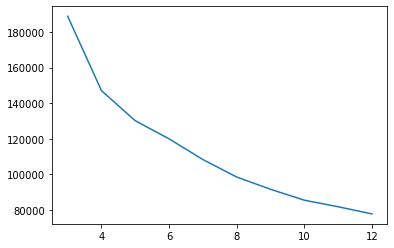

In [122]:
plt.plot(n_clusters,inertias)

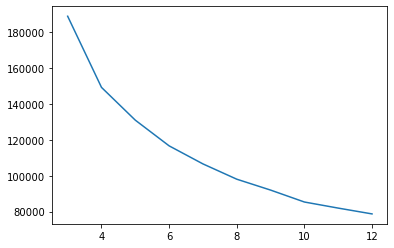

In [123]:
scaled = Stdrshp(prepandemic, pivot_cols, constant_cols)
n_clusters = [k for k in range(3,13)]
inertias = []
for k in n_clusters:
    df, inertia = make_clusters(scaled, k = k)
    inertias.append(inertia)
    
plt.plot(n_clusters,inertias)

In [128]:
prepandemic, prepandemic_inertia = run_Kmeans(prepandemic, pivot_cols, constant_cols, k = 5)
pandemic, pandemic_inertia = run_Kmeans(pandemic, pivot_cols, constant_cols, k = 5)

In [129]:
pandemic_inertia

121908.89368010829

In [130]:
# We want to compare pandemic_inertia to the inertia we would have in 2020 if we used the
# 2019 clustering
combined = pandemic.join(prepandemic[['cluster']], how='left',rsuffix='pre')
combined[['clusterpre']] = combined[['clusterpre']].fillna(value=-1)
combined['clusterpre'] = combined['clusterpre'].astype(int)

In [131]:
cols = combined.columns
cols = cols[:-2]
n = len(combined.columns)

In [132]:
def get_inertia(df, cols, cluster_col):
    mask = df[cluster_col] > -1
    n = len(df.index)
    filtered = df[mask]
    m = len(filtered.index)
    se = ((df[cols] - df.groupby(cluster_col)[cols].transform('mean'))**2).to_numpy().sum()
    return se*(n/m)

get_inertia(combined, cols, 'clusterpre')

245795.3974635573

In [133]:
#worst case scenario
combined['newcol'] = 1
get_inertia(combined, cols, 'newcol')

363528.00000000006

In [65]:
combined.groupby('cluster').size()

cluster
0       28
1    16925
2      173
3     3054
4       16
dtype: int64

In [66]:
combined.groupby('clusterpre').size()

clusterpre
-1     2407
 0     4305
 1    12453
 2      118
 3      335
 4      578
dtype: int64

In [153]:
big_cats = philly_patterns.groupby('top_category').size().sort_values(ascending = False)[:5]

In [155]:
big_cats = big_cats.index

In [156]:
def category_groups(x):
    if x in big_cats: 
        return x 
    else: 
        return 'other'

In [157]:
philly_patterns['top_category_simple'] = philly_patterns.top_category.apply(category_groups)

In [158]:
philly_patterns['top_category_simple'].unique()

array(['other', 'Restaurants and Other Eating Places',
       'Child Day Care Services', 'Religious Organizations',
       'Grocery Stores', 'Other Amusement and Recreation Industries'],
      dtype=object)

In [159]:
mask = philly_patterns['date_range_start'] < '2020-03-01' 
cats = philly_patterns.loc[~mask,].copy()
cats = cats.loc[
        cats.groupby('safegraph_place_id').cumcount() == 0,
        ['safegraph_place_id', 'top_category_simple']
    ]

In [161]:
combined.drop(columns = 'top_category_simple', inplace = True)

In [162]:
combined = combined.join(cats.set_index('safegraph_place_id'), how = 'left')

In [164]:
pd.crosstab(combined.clusterpre, combined.top_category_simple, dropna=False)

top_category_simple,Child Day Care Services,Grocery Stores,Other Amusement and Recreation Industries,Religious Organizations,Restaurants and Other Eating Places,other
clusterpre,,,,,,
-1,32,23,41,53,174,2084
0,790,308,246,848,1469,7685
1,0,31,17,1,78,173
2,181,412,248,131,1592,2367
3,0,2,3,0,10,83
4,12,72,101,3,406,520
